In [25]:
import pandas as pd
import numpy as np

In [26]:
pd.set_option('display.max_columns', None)

In [27]:
data = pd.read_csv("preprocessed_df3.csv")

In [28]:
data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportSeqID,Origin,OriginCityName,OriginState,DestAirportSeqID,Dest,DestCityName,DestState,CRSDepTime,DepDelay,CRSArrTime,Cancelled,Diverted,CRSElapsedTime,Distance,DaysSince,is_holiday,is_day_before_holiday,is_holiday_week,MinSince,OriginFlightDensity,Visibility,WindSpeed,SevereWeather,BadWeather
0,2014,1,1,1,3,2014-01-01,OO,N724SK,4974,1039705,ATL,"Atlanta, GA",GA,1226603,IAH,"Houston, TX",TX,600,-3.0,721,0.0,0.0,141.0,689.0,0,1,0,1,360,2.0,10.0,5.0,0,0
1,2014,1,1,1,3,2014-01-01,AA,N002AA,1315,1039705,ATL,"Atlanta, GA",GA,1129803,DFW,"Dallas/Fort Worth, TX",TX,700,-2.0,830,0.0,0.0,150.0,731.0,0,1,0,1,420,3.0,10.0,5.0,0,0
2,2014,1,1,1,3,2014-01-01,UA,N76288,1134,1039705,ATL,"Atlanta, GA",GA,1393003,ORD,"Chicago, IL",IL,707,2.0,815,0.0,0.0,128.0,606.0,0,1,0,1,427,3.0,10.0,5.0,0,0
3,2014,1,1,1,3,2014-01-01,DL,N709DN,110,1039705,ATL,"Atlanta, GA",GA,1289203,LAX,"Los Angeles, CA",CA,810,21.0,1004,0.0,0.0,294.0,1947.0,0,1,0,1,490,6.0,10.0,3.0,0,0
4,2014,1,1,1,3,2014-01-01,DL,N654DL,1347,1039705,ATL,"Atlanta, GA",GA,1477101,SFO,"San Francisco, CA",CA,815,-2.0,1038,0.0,0.0,323.0,2139.0,0,1,0,1,495,6.0,10.0,3.0,0,0


In [29]:
data = data.drop(columns = ['FlightDate', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginCityName', 'OriginState', 'DestCityName', 'DestState', 'MinSince'])


In [30]:
data = pd.get_dummies(data)

In [31]:
data['Delay'] = data['DepDelay'].apply(lambda x: 1 if x < 15.0 else 0)


In [32]:
data = data.drop(columns = ['DepDelay'])

In [33]:
from sklearn.model_selection import train_test_split

X = data.drop('Delay', axis=1)
y = data['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1)


In [ ]:

#remove any rows with DepDelay <= 0
df_new = data[data['DepDelay'] > 0]

#Keep these columns
df_new = df_new[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'CRSDepTime', 'DepDelay', 'CRSElapsedTime', 'Distance', 'is_holiday_week', 'TotalDensity', 'Visibility', 'WindSpeed', 'SevereWeather', 'BadWeather']]

#turn all non-numerical data into numerical data, using .factorize()
object_cols = df_new.select_dtypes(include='object').columns
df_nums = df_new.copy()
for col in object_cols:
    df_nums[col],  = pd.factorize(df_new[col])

#convert DepDelay into bins
bins = [15, 30, 60, 120, 300, df_nums['DepDelay'].max()]
labels = [0, 1, 2, 3, 4]
df_nums['DepDelay'] = pd.cut(df_nums['DepDelay'], bins=bins, labels=labels)
#drop rows with NaN
df_nums = df_nums.dropna()

#oversample the data to balance the classes
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X = df_nums.drop(columns=['DepDelay'])
y = df_nums['DepDelay']

X_resampled, y_resampled = ros.fit_resample(X, y)

#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

In [34]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

xgb_classifier = xgb.XGBClassifier()

param_grid = {
    'max_depth': [3],
    'learning_rate': [0.2],
    'n_estimators': [100],
    'gamma': [0.2]
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_xgb_classifier = grid_search.best_estimator_

y_pred = best_xgb_classifier.predict(X_test)

testing_accuracy = accuracy_score(y_test, y_pred)

print(testing_accuracy)

0.7981953642384106


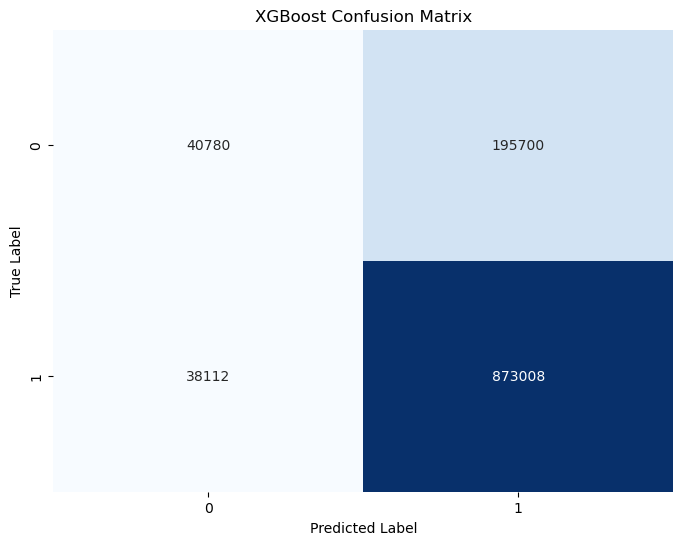

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [38]:
feature_importances = best_xgb_classifier.feature_importances_

top_feature_indices = feature_importances.argsort()[::-1]

top_features = [(X_train.columns[i], feature_importances[i]) for i in top_feature_indices]
print("Top features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top features:
CRSDepTime: 0.13519437611103058
Reporting_Airline_WN: 0.11107633262872696
SevereWeather: 0.08239080011844635
CRSArrTime: 0.07548076659440994
Visibility: 0.06928591430187225
DestAirportSeqID: 0.053225867450237274
Month: 0.041327688843011856
Origin_ORD: 0.032815366983413696
Reporting_Airline_DL: 0.031719256192445755
DaysSince: 0.029335297644138336
Reporting_Airline_UA: 0.02891254425048828
Year: 0.02381368912756443
OriginAirportSeqID: 0.023104172199964523
DayofMonth: 0.02129523456096649
Origin_LAX: 0.019188398495316505
Origin_PHX: 0.018162760883569717
is_holiday_week: 0.017527729272842407
Dest_CLT: 0.016654590144753456
DayOfWeek: 0.015868518501520157
Cancelled: 0.013562080450356007
WindSpeed: 0.013542615808546543
BadWeather: 0.012471713125705719
CRSElapsedTime: 0.011897618882358074
Dest_PHX: 0.01063455268740654
Reporting_Airline_AA: 0.010568908415734768
is_holiday: 0.010388300754129887
Diverted: 0.009905576705932617
is_day_before_holiday: 0.00911666452884674
Quarter: 0.00886

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

predictions = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print("Random Forest Classifier Accuracy:", accuracy)


Random Forest Classifier Accuracy: 0.7962600209132101


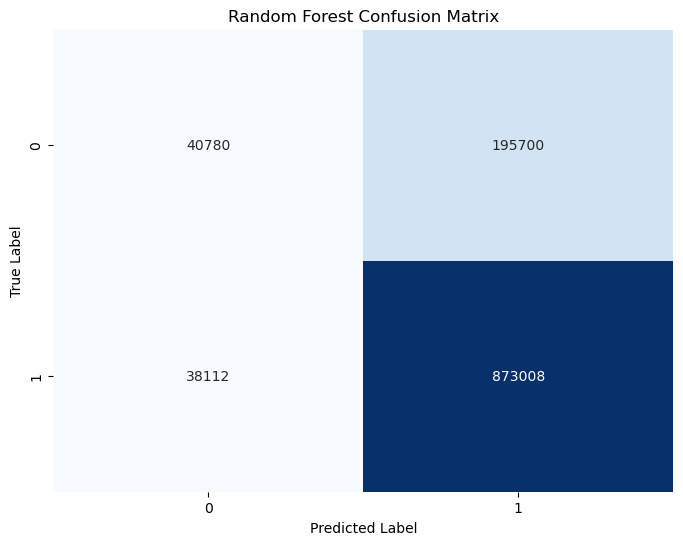

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [22]:
X_train

,Year,Quarter,Month,DayofMonth,DayOfWeek,OriginAirportSeqID,DestAirportSeqID,CRSDepTime,CRSArrTime,Cancelled,Diverted,CRSElapsedTime,Distance,DaysSince,is_holiday,is_day_before_holiday,is_holiday_week,OriginFlightDensity,Visibility,WindSpeed,SevereWeather,BadWeather,Reporting_Airline_AA,Reporting_Airline_DL,Reporting_Airline_OO,Reporting_Airline_UA,Reporting_Airline_WN,Origin_ATL,Origin_CLT,Origin_DEN,Origin_DFW,Origin_IAH,Origin_LAX,Origin_ORD,Origin_PHX,Origin_SFO,Dest_ATL,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO
67864,2015,4,11,23,1,1039705,1129202,1910,2039,0.0,0.0,209.0,1199.0,691,0,0,1,20.0,10.0,5.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
79286,2016,1,3,11,5,1039705,1129202,2005,2134,0.0,0.0,209.0,1199.0,800,0,0,0,23.0,10.0,3.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1048213,2018,4,10,5,5,1289208,1477104,1400,1528,0.0,0.0,88.0,337.0,1738,0,0,1,28.0,10.0,11.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
353133,2015,4,11,10,2,1129202,1410702,1150,1345,0.0,0.0,115.0,602.0,678,0,1,1,27.0,10.0,10.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1251823,2018,3,7,1,7,1393006,1129806,709,930,0.0,0.0,141.0,802.0,1642,0,0,1,22.0,10.0,13.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836489,2014,2,6,20,5,1289203,1129803,1900,5,0.0,0.0,185.0,1235.0,170,0,0,0,21.0,8.0,9.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
491263,2014,2,4,19,6,1129803,1039705,1840,2145,0.0,0.0,125.0,731.0,108,0,0,0,15.0,10.0,11.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
470924,2018,4,10,6,6,1129202,1410702,1815,1915,0.0,0.0,120.0,602.0,1739,0,0,1,13.0,10.0,10.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
491755,2014,2,4,24,4,1129803,1393003,1320,1535,0.0,0.0,135.0,802.0,113,0,0,0,22.0,10.0,16.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
importances = rf_classifier.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. Feature 13 (0.131520)
2. Feature 3 (0.110996)
3. Feature 7 (0.095098)
4. Feature 19 (0.093288)
5. Feature 8 (0.092094)
6. Feature 17 (0.080208)
7. Feature 4 (0.072518)
8. Feature 11 (0.067277)
9. Feature 2 (0.048484)
10. Feature 18 (0.021997)
11. Feature 1 (0.018608)
12. Feature 0 (0.018040)
13. Feature 12 (0.018003)
14. Feature 6 (0.016563)
15. Feature 5 (0.015467)
16. Feature 16 (0.014664)
17. Feature 26 (0.011178)
18. Feature 22 (0.006480)
19. Feature 25 (0.005878)
20. Feature 14 (0.004190)
21. Feature 15 (0.004098)
22. Feature 23 (0.003689)
23. Feature 21 (0.003129)
24. Feature 24 (0.003124)
25. Feature 41 (0.002798)
26. Feature 32 (0.002771)
27. Feature 42 (0.002619)
28. Feature 33 (0.002547)
29. Feature 30 (0.002509)
30. Feature 39 (0.002435)
31. Feature 38 (0.002429)
32. Feature 43 (0.002367)
33. Feature 44 (0.002345)
34. Feature 29 (0.002280)
35. Feature 35 (0.002198)
36. Feature 20 (0.002174)
37. Feature 31 (0.002150)
38. Feature 40 (0.002129)
39. Feature 3

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

svm_classifier = SVC()

param_grid = {
    'C': [1.0],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_svm_classifier = grid_search.best_estimator_

y_pred = best_svm_classifier.predict(X_test)

testing_accuracy = accuracy_score(y_test, y_pred)

print(testing_accuracy)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

logistic_classifier = LogisticRegression()

param_grid = {
    'C': [1.0],
    'solver': ['liblinear'],
    'penalty': ['l2']
}

grid_search = GridSearchCV(estimator=logistic_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_logistic_classifier = grid_search.best_estimator_

y_pred = best_logistic_classifier.predict(X_test)

testing_accuracy = accuracy_score(y_test, y_pred)

print(testing_accuracy)

0.793935169048449


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.7930106308818403
              precision    recall  f1-score   support

           0       0.41      0.01      0.02    236480
           1       0.80      1.00      0.88    911120

    accuracy                           0.79   1147600
   macro avg       0.60      0.50      0.45   1147600
weighted avg       0.72      0.79      0.71   1147600



In [41]:

means = nb_classifier.theta_

variances = nb_classifier.var_

total_variance = variances.sum(axis=0)

feature_importance = (total_variance / total_variance.sum()) * 100

for i, importance in enumerate(feature_importance):
    print(f"Feature {i+1}: {importance:.2f}%")


Feature 1: 0.00%
Feature 2: 0.00%
Feature 3: 0.00%
Feature 4: 0.00%
Feature 5: 0.00%
Feature 6: 49.64%
Feature 7: 50.36%
Feature 8: 0.00%
Feature 9: 0.00%
Feature 10: 0.00%
Feature 11: 0.00%
Feature 12: 0.00%
Feature 13: 0.00%
Feature 14: 0.00%
Feature 15: 0.00%
Feature 16: 0.00%
Feature 17: 0.00%
Feature 18: 0.00%
Feature 19: 0.00%
Feature 20: 0.00%
Feature 21: 0.00%
Feature 22: 0.00%
Feature 23: 0.00%
Feature 24: 0.00%
Feature 25: 0.00%
Feature 26: 0.00%
Feature 27: 0.00%
Feature 28: 0.00%
Feature 29: 0.00%
Feature 30: 0.00%
Feature 31: 0.00%
Feature 32: 0.00%
Feature 33: 0.00%
Feature 34: 0.00%
Feature 35: 0.00%
Feature 36: 0.00%
Feature 37: 0.00%
Feature 38: 0.00%
Feature 39: 0.00%
Feature 40: 0.00%
Feature 41: 0.00%
Feature 42: 0.00%
Feature 43: 0.00%
Feature 44: 0.00%
Feature 45: 0.00%
